<a href="https://colab.research.google.com/github/Mohamed-Mohamed-Ibrahim/Face-Recognition/blob/main/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
gm = GaussianMixture(n_components=2, random_state=0).fit(X)
gm.means_
gm.predict([[0, 0], [12, 3]])

array([1, 0])

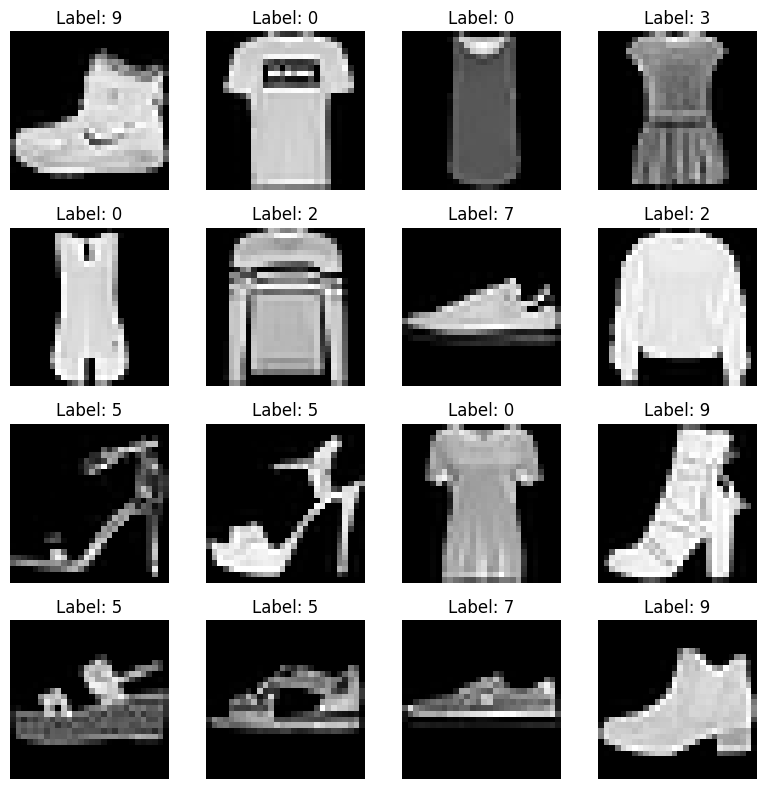

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

X = np.array([np.arange(28)])
y = np.array([])

# Define the transformation
transform = transforms.ToTensor()

# Load the dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Create a subplot with 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

# Loop through each subplot and plot an image
for i in range(4):
    for j in range(4):
        image, label = train_dataset[i * 4 + j]  # Get image and label
        image_numpy = image.numpy().squeeze()    # Convert image tensor to numpy array
        # print(len(image_numpy))
        X = np.append(X, image_numpy, axis=0)
        y = np.append(y, label)
        axs[i, j].imshow(image_numpy, cmap='gray')  # Plot the image
        axs[i, j].axis('off')  # Turn off axis
        axs[i, j].set_title(f"Label: {label}")  # Set title with label
X = np.delete(X, 0, axis=0)

plt.tight_layout()  # Adjust layout
plt.show()  # Show plot


In [ ]:
print(f"X: {X}, size: {X.shape}")
print(f"y: {y}, size: {len(y)}")

X: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], size: (448, 28)
y: [9. 0. 0. 3. 0. 2. 7. 2. 5. 5. 0. 9. 5. 5. 7. 9.], size: 16


In [ ]:
40 + np.zeros(4)

array([40., 40., 40., 40.])

In [17]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import multivariate_normal


class GMM(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=1, tol=0.001, reg_covar=1e-06, max_iter=100, verbose=False):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.max_iter = max_iter
        self.verbose = verbose
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None

    def fit(self, X):
        best_m = None
        best_c = None
        best_w = None
        best_log_likelihood = -np.inf

        for _ in range(10):
            self.__fit(X)
            ll = self.log_likelihood(X)
            if ll > best_log_likelihood:
                best_log_likelihood = ll
                best_m = self.means_
                best_c = self.covariances_
                best_w = self.weights_
            self.means_ = None
            self.covariances_ = None
            self.weights_ = None
        self.means_ = best_m
        self.covariances_ = best_c
        self.weights_ = best_w


    def __fit(self, X):

        n_samples, n_features = X.shape
        self.means_ = np.random.rand(self.n_components, n_features)*20 - 10
        self.covariances_ = np.zeros((self.n_components, n_features, n_features))
        for i in range(self.n_components):
            self.covariances_[i] = np.eye(n_features)
        self.weights_ = (1/self.n_components) + np.zeros(self.n_components)

        r = np.zeros((self.n_components, n_samples))

        for _ in range(self.max_iter):

            if self.verbose and self.max_iter % 50 == 0:
                print(f"Iteration: {_} -> Means {self.means_} -> Var {self.covariances_} -> Weights {self.weights_}")

            # E-step
            # Assign r using posterior probability
            for i in range(self.n_components):
                r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, self.means_[i], self.covariances_[i])

            # Normalization
            for i in range(n_samples):
                r[:, i] = r[:, i] / np.sum(r[:, i])

            old_w = self.weights_.copy()
            old_m = self.means_.copy()
            old_c = self.covariances_.copy()

            # M-step
            for i in range(self.n_components):

                self.weights_[i] = np.sum(r[i, :]) / n_samples

                for j in range(n_features):
                    self.means_[i][j] = np.sum(r[i, :] * X[:, j]) / np.sum(r[i, :])
                # self.means_[i] = (r[i, :, np.newaxis] * X).sum(axis=0) / np.sum(r[i, :])
                    for k in range(n_features):
                        self.covariances_[i][j, k] = np.sum(r[i, :] * (X[:, j] - self.means_[i][j]) * (X[:, k] - self.means_[i][k])) / np.sum(r[i, :])

                # diff = X - self.means_[i]
                # self.covariances_[i] = (r[i, :, np.newaxis, np.newaxis] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / np.sum(r[i, :])

                # Regularize covariance
                self.covariances_[i] += self.reg_covar * np.eye(n_features)

            if np.all(np.abs(old_w - self.weights_) < self.tol) and np.all(np.abs(old_m - self.means_) < self.tol) and np.all(np.abs(old_c - self.covariances_) < self.tol):
                break


    def predict(self, X):
        n_samples = len(X)

        r = np.zeros((self.n_components, n_samples))

        for i in range(self.n_components):
            r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, self.means_[i], self.covariances_[i])

        return np.argmax(r, axis=0)

    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for k in range(self.n_components):
                tot += self.weights_[k] * multivariate_normal.pdf(X, mean=self.means_[k], cov=self.covariances_[k])
            ll.append(np.log(tot))
        return np.sum(ll)

In [10]:
np.zeros((1, 2))

array([[0., 0.]])

In [633]:
import numpy as np
from sklearn.mixture import GaussianMixture
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
gm = GaussianMixture(n_components=2, verbose=1).fit(X)
print(gm.means_)
print(gm.covariances_)
print(gm.weights_)
gm.predict([[0, 0], [12, 3]])

Initialization 0
Initialization converged.
[[10.  2.]
 [ 1.  2.]]
[[[1.00000000e-06 1.20958672e-29]
  [1.20958672e-29 2.66666767e+00]]

 [[1.00000000e-06 1.25724707e-30]
  [1.25724707e-30 2.66666767e+00]]]
[0.5 0.5]


array([1, 0])

In [663]:
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
gmm = GMM(n_components=2)
gmm.fit(X)
print(gmm.means_)
print(gmm.covariances_)
print(gmm.weights_)
print(gmm.predict([[0, 0], [12, 3]]))
gmm.log_likelihood(X)

[[1.         0.        ]
 [6.39999996 2.39999998]]
[[[ 1.00000000e-06  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e-06]]

 [[ 1.94400011e+01 -2.15999988e+00]
  [-2.15999988e+00  2.24000103e+00]]]
[0.16666666 0.83333334]
[1 1]


np.float64(-84.39791401648512)

# Resourses

In [ ]:
https://www.geeksforgeeks.org/how-to-load-fashion-mnist-dataset-using-pytorch/
https://youtu.be/wT2yLNUfyoM
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
https://github.com/scikit-learn/scikit-learn/blob/98ed9dc73/sklearn/mixture/_gaussian_mixture.py#L509

In [645]:
import numpy as np
from sklearn.mixture import GaussianMixture
X = np.array([[1], [1], [1], [10], [10], [10]])
gm = GaussianMixture(n_components=2, random_state=0).fit(X)
print(gm.means_)
print(gm.covariances_)
print(gm.weights_)
gm.predict([[0], [12]])

[[10.]
 [ 1.]]
[[[1.e-06]]

 [[1.e-06]]]
[0.5 0.5]


array([1, 0])

In [105]:
np.zeros(1, 3, 2)

TypeError: Cannot interpret '3' as a data type

<ipython-input-19-3a9e31bf12d0>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=30, cmap='viridis')


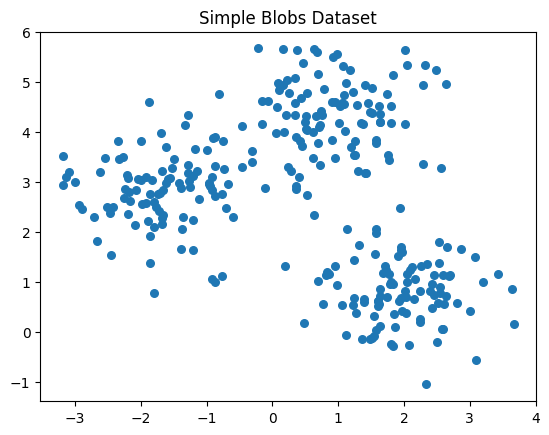

In [19]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic data
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.70, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=30, cmap='viridis')
plt.title("Simple Blobs Dataset")
plt.show()


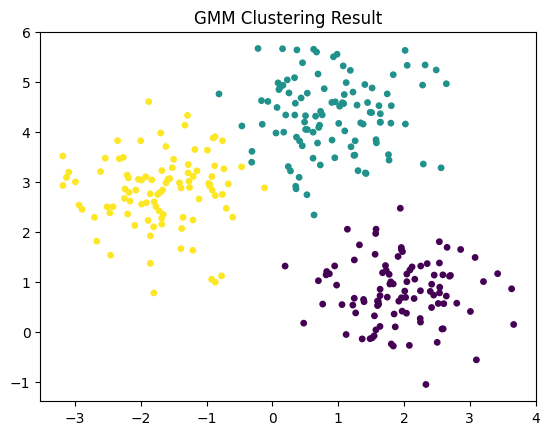

In [22]:
gmm = GMM(n_components=3, tol=1e-9, max_iter=100)
gmm.fit(X)
labels = gmm.predict(X)


plt.scatter(X[:, 0], X[:, 1], c=labels, s=15, cmap='viridis')
plt.title("GMM Clustering Result")
plt.show()


# Chatgpt Implementation

In [631]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import multivariate_normal


class GMM(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=1, tol=0.001, reg_covar=1e-6, max_iter=100):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.max_iter = max_iter
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None

    def fit(self, X):
        n_samples, n_features = X.shape
        self.means_ = np.random.rand(self.n_components, n_features) * 20 - 10
        self.covariances_ = np.array([np.eye(n_features) for _ in range(self.n_components)])
        self.weights_ = np.ones(self.n_components) / self.n_components

        r = np.zeros((self.n_components, n_samples))

        for iteration in range(self.max_iter):
            # print(f"Iteration {iteration}: Means {self.means_}")

            # E-step
            for k in range(self.n_components):
                r[k, :] = self.weights_[k] * multivariate_normal.pdf(X, mean=self.means_[k], cov=self.covariances_[k])

            r /= np.sum(r, axis=0)  # Normalize responsibilities

            # Save old parameters
            old_means = self.means_.copy()
            old_covariances = self.covariances_.copy()
            old_weights = self.weights_.copy()

            # M-step
            Nk = np.sum(r, axis=1)  # Effective number of points assigned to each cluster

            for k in range(self.n_components):
                self.weights_[k] = Nk[k] / n_samples
                self.means_[k] = np.sum(r[k, :, np.newaxis] * X, axis=0) / Nk[k]

                diff = X - self.means_[k]
                self.covariances_[k] = (r[k, :, np.newaxis, np.newaxis] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / Nk[k]

                # Regularize covariance
                self.covariances_[k] += self.reg_covar * np.eye(n_features)

            # Convergence check
            if (np.all(np.abs(self.weights_ - old_weights) < self.tol) and
                np.all(np.abs(self.means_ - old_means) < self.tol) and
                np.all(np.abs(self.covariances_ - old_covariances) < self.tol)):
                print("Converged.")
                break

    def predict(self, X):
        n_samples = X.shape[0]
        r = np.zeros((self.n_components, n_samples))

        for k in range(self.n_components):
            r[k, :] = self.weights_[k] * multivariate_normal.pdf(X, mean=self.means_[k], cov=self.covariances_[k])

        return np.argmax(r, axis=0)

    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for k in range(self.n_components):
                tot += self.weights_[k] * multivariate_normal.pdf(X, mean=self.means_[k], cov=self.covariances_[k])
            ll.append(np.log(tot))
        return np.sum(ll)


In [608]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import multivariate_normal


class GMMs(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=1, tol=0.001, reg_covar=1e-06, max_iter=100, covariance_type='full'):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.max_iter = max_iter
        self.covariance_type = covariance_type
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None

    def fit(self, X):
        n_samples, n_features = X.shape
        self.means_ = np.random.rand(self.n_components, n_features) * 20 - 10  # Random initialization
        self.covariances_ = np.zeros((self.n_components, n_features, n_features))
        for i in range(self.n_components):
            self.covariances_[i] = np.eye(n_features)
        self.weights_ = np.full(self.n_components, 1 / self.n_components)  # Uniform weights

        r = np.zeros((self.n_components, n_samples))  # Responsibility matrix

        for _ in range(self.max_iter):
            # E-step: Compute responsibilities
            for i in range(self.n_components):
                r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, self.means_[i], self.covariances_[i])

            # Normalize responsibilities (posterior probabilities)
            r /= np.sum(r, axis=0)

            # Store old parameters for convergence check
            old_w = self.weights_.copy()
            old_m = self.means_.copy()
            old_c = self.covariances_.copy()

            # M-step: Update parameters
            for i in range(self.n_components):
                Nk = np.sum(r[i, :])  # Effective number of points assigned to component i

                # Update weights
                self.weights_[i] = Nk / n_samples

                # Update means
                self.means_[i] = np.sum(r[i, :, np.newaxis] * X, axis=0) / Nk

                # Update covariances based on the covariance type
                diff = X - self.means_[i]
                if self.covariance_type == 'full':
                    self.covariances_[i] = (r[i, :, np.newaxis, np.newaxis] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / Nk
                elif self.covariance_type == 'diagonal':
                    self.covariances_[i] = np.diag(np.sum(r[i, :] * np.square(diff), axis=0) / Nk)
                elif self.covariance_type == 'tied':
                    if i == 0:
                        self.covariances_[i] = np.zeros((n_features, n_features))
                    self.covariances_[i] += (r[i, :, np.newaxis] * diff).T @ diff / Nk
                else:
                    raise ValueError("Unknown covariance_type. Choose from 'full', 'diagonal', 'tied'.")

                # Regularize covariance matrix to ensure it's positive definite
                self.covariances_[i] += self.reg_covar * np.eye(n_features)

            # Check for convergence (log-likelihood change)
            if np.all(np.abs(old_w - self.weights_) < self.tol) and np.all(np.abs(old_m - self.means_) < self.tol) and np.all(np.abs(old_c - self.covariances_) < self.tol):
                break

    def predict(self, X):
        # Compute the responsibilities for each sample
        n_samples = len(X)
        r = np.zeros((self.n_components, n_samples))

        for i in range(self.n_components):
            r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, self.means_[i], self.covariances_[i])

        # Assign each sample to the component with the highest responsibility
        return np.argmax(r, axis=0)


In [619]:
!pip install scipy

In [625]:
import numpy as np
# from scipy import random
from numpy import random

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
        self.colors = colors

    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))

    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)

    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]

    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)

    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [630]:
# Training the GMMo using EM
gmmo = GMM(3, 2)

# Initialize EM algo with data
gmmo.init_em(X)
num_iters = 30
# Saving log-likelihood
log_likelihood = [gmmo.log_likelihood(X)]
# plotting
# plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmmo.e_step()
    # M-step
    gmmo.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmmo.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    # plot(title="Iteration: " + str(e+1))

Iteration: 1, log-likelihood: -590.4994
Iteration: 2, log-likelihood: -579.0975
Iteration: 3, log-likelihood: -568.8451
Iteration: 4, log-likelihood: -556.6175
Iteration: 5, log-likelihood: -541.2648
Iteration: 6, log-likelihood: -515.7311
Iteration: 7, log-likelihood: -467.1746
Iteration: 8, log-likelihood: -451.6850
Iteration: 9, log-likelihood: -451.6850
Iteration: 10, log-likelihood: -451.6850
Iteration: 11, log-likelihood: -451.6850
Iteration: 12, log-likelihood: -451.6850
Iteration: 13, log-likelihood: -451.6850
Iteration: 14, log-likelihood: -451.6850
Iteration: 15, log-likelihood: -451.6850
Iteration: 16, log-likelihood: -451.6850
Iteration: 17, log-likelihood: -451.6850
Iteration: 18, log-likelihood: -451.6850
Iteration: 19, log-likelihood: -451.6850
Iteration: 20, log-likelihood: -451.6850
Iteration: 21, log-likelihood: -451.6850
Iteration: 22, log-likelihood: -451.6850
Iteration: 23, log-likelihood: -451.6850
Iteration: 24, log-likelihood: -451.6850
Iteration: 25, log-likeli

In [667]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import multivariate_normal


class GMMf(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=1, tol=1e-3, reg_covar=1e-6, max_iter=100, verbose=False):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.max_iter = max_iter
        self.verbose = verbose

        self.means_ = None
        self.covariances_ = None
        self.weights_ = None

    def fit(self, X):
        n_samples, n_features = X.shape

        # Initialize parameters
        self.means_ = np.random.rand(self.n_components, n_features) * 20 - 10
        self.covariances_ = np.array([np.eye(n_features) for _ in range(self.n_components)])
        self.weights_ = np.ones(self.n_components) / self.n_components

        r = np.zeros((self.n_components, n_samples))

        prev_log_likelihood = None

        for iteration in range(self.max_iter):
            # E-step
            for i in range(self.n_components):
                r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, mean=self.means_[i], cov=self.covariances_[i])

            r /= r.sum(axis=0, keepdims=True) + 1e-10  # Normalize responsibilities

            # M-step
            Nk = r.sum(axis=1)  # shape (n_components,)

            self.weights_ = Nk / n_samples

            self.means_ = (r @ X) / Nk[:, np.newaxis]

            for i in range(self.n_components):
                diff = X - self.means_[i]
                self.covariances_[i] = (r[i, :, np.newaxis, np.newaxis] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / Nk[i]
                self.covariances_[i] += self.reg_covar * np.eye(n_features)

            # Check convergence using log-likelihood
            log_likelihood = self.log_likelihood(X)
            if self.verbose:
                print(f"Iteration {iteration}: log-likelihood = {log_likelihood:.6f}")

            if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < self.tol:
                if self.verbose:
                    print(f"Converged at iteration {iteration}")
                break
            prev_log_likelihood = log_likelihood

    def predict(self, X):
        n_samples = X.shape[0]
        r = np.zeros((self.n_components, n_samples))

        for i in range(self.n_components):
            r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, mean=self.means_[i], cov=self.covariances_[i])

        return np.argmax(r, axis=0)

    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters.
        '''
        n_samples = X.shape[0]
        total_likelihood = np.zeros(n_samples)

        for i in range(self.n_components):
            total_likelihood += self.weights_[i] * multivariate_normal.pdf(X, mean=self.means_[i], cov=self.covariances_[i])

        log_likelihood = np.sum(np.log(total_likelihood + 1e-10))  # Add epsilon to avoid log(0)
        return log_likelihood
